In [1]:
import pandas as pd
import geopandas as gpd
import pathlib
import numpy as np
import geojson

import matplotlib.pyplot as plt

In [2]:
data_dir = pathlib.Path('~/data/river/dtv/betrekkingslijnen')

In [3]:
!wget -O {data_dir / 'kmmarkeringen.geojson' } 'https://geodata.nationaalgeoregister.nl/nwbvaarwegen/wfs?request=GetFeature&service=WFS&version=2.0.0&outputFormat=json&typeNames=nwbvaarwegen:kmmarkeringen'

!wget -O {data_dir / 'vaarwegvakken.geojson' } 'https://geodata.nationaalgeoregister.nl/nwbvaarwegen/wfs?request=GetFeature&service=WFS&version=1.1.0&outputFormat=json&typeName=vaarwegvakken'


--2022-05-31 20:29:43--  https://geodata.nationaalgeoregister.nl/nwbvaarwegen/wfs?request=GetFeature&service=WFS&version=2.0.0&outputFormat=json&typeNames=nwbvaarwegen:kmmarkeringen
SSL_INIT
Resolving geodata.nationaalgeoregister.nl (geodata.nationaalgeoregister.nl)... 2001:67c:2f04:f300::123, 145.77.103.123
Connecting to geodata.nationaalgeoregister.nl (geodata.nationaalgeoregister.nl)|2001:67c:2f04:f300::123|:443... connected.
HTTP request sent, awaiting response... 200 
Length: unspecified [application/json]
Saving to: ‘/Users/baart_f/data/river/dtv/betrekkingslijnen/kmmarkeringen.geojson’

/Users/baart_f/data     [  <=>               ] 721.36K  2.67MB/s    in 0.3s    

2022-05-31 20:29:43 (2.67 MB/s) - ‘/Users/baart_f/data/river/dtv/betrekkingslijnen/kmmarkeringen.geojson’ saved [738676]

--2022-05-31 20:29:43--  https://geodata.nationaalgeoregister.nl/nwbvaarwegen/wfs?request=GetFeature&service=WFS&version=1.1.0&outputFormat=json&typeName=vaarwegvakken
SSL_INIT
Resolving geodata.n

In [4]:
# betrekkingslijnen (From Remi)
betrekkingslijnen_lobith_path = data_dir / 'Betrekkingslijnen2018' / 'Betrekkingslijnen_2018_h-Lobith_650-1780_rkm.xlsx'
kmmarkering_path = data_dir / 'kmmarkeringen.geojson'
vaarwegvakken_path = data_dir / 'vaarwegvakken.geojson'

# Excel sheet names with corresponding vaarwegvakken names
sheet_names = {
    "Bovenrijn-Waal": "Boven-Rijn|Waal",
    "Pkan-NRijn-Lek": "Pannerdensch Kanaal|Neder-Rijn|Lek",
    "IJssel": "IJssel"
}


name_vaarweg_codes = {
    "Bovenrijn-Waal": "101",
    "IJssel": "084",
    "Pkan-NRijn-Lek": "103"
}

In [5]:
# Read betrekingslijnen  NOTE: usecols is hardcoded!
lobith_df = pd.read_excel(betrekkingslijnen_lobith_path, sheet_name=list(sheet_names.keys()), skiprows=[0, 1, 3, 4, 5], header=0, usecols="B:DL", index_col=0)


In [6]:
# Column: Discharge Lobith [m3/s]
# Row: Kilometermarkering
# Cell: ws -> waterstand [m+NAP]

 # (name='km-markering')

river_dfs = []
for sheet_name in sheet_names:
    river_df = lobith_df[sheet_name]
    river_with_km = river_df.reset_index().rename(columns={'index': 'km_markering'})
    river_flat = river_with_km.melt(id_vars=['km_markering'], value_name='waterlevel')
    river_flat = river_flat.rename(columns={'variable': 'discharge'})
    river_flat['river'] = sheet_name
    river_flat['vrt_code'] = name_vaarweg_codes[sheet_name]
    river_dfs.append(river_flat)

river_df = pd.concat(river_dfs)
river_df = river_df.dropna()

river_df['km_markering_int'] = np.floor(river_df['km_markering']).astype('int')
river_df


,km_markering,discharge,waterlevel,river,vrt_code,km_markering_int
0,854.0,703.3,7.930000,Bovenrijn-Waal,101,854
1,855.0,703.3,7.710000,Bovenrijn-Waal,101,855
2,856.0,703.3,7.430000,Bovenrijn-Waal,101,856
3,857.0,703.3,7.210000,Bovenrijn-Waal,101,857
4,858.0,703.3,7.040000,Bovenrijn-Waal,101,858
...,...,...,...,...,...,...
15157,1002.0,16140.64,1.070000,IJssel,084,1002
15158,1003.0,16140.64,0.990000,IJssel,084,1003
15159,1004.0,16140.64,0.860000,IJssel,084,1004
15160,1005.0,16140.64,0.750000,IJssel,084,1005


<AxesSubplot:>

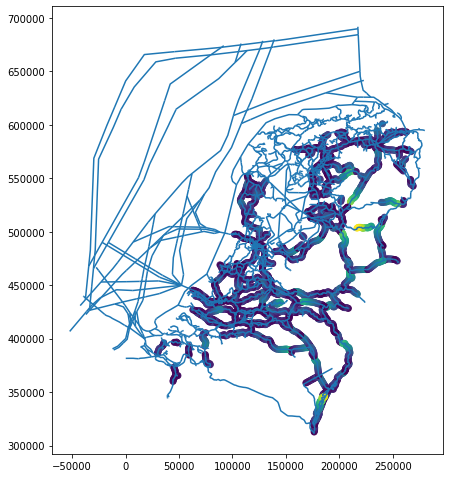

In [7]:
kmm_gdf= gpd.read_file(kmmarkering_path, crs=28992)
vwv_gdf = gpd.read_file(vaarwegvakken_path, crs=28992)

fig, ax = plt.subplots(figsize=(7, 13))
kmm_gdf.plot(ax=ax, column='afstand')
vwv_gdf.plot(ax=ax)


In [23]:
river_with_discharges = []
for vrt_code in set(river_df.vrt_code):
    idx = vwv_gdf.vrt_code  == vrt_code
    vwk_ids = vwv_gdf[idx].vwk_id
    # select relevant kilometerpalen using the vakken ids
    kmm_gdf_idx = kmm_gdf.vwk_id.isin(vwk_ids)
    # make a copy so we can alter it
    kmm_gdf_selected = kmm_gdf[kmm_gdf_idx].copy()
    # add integer version
    kmm_gdf_selected['km_markering_int'] = np.floor(kmm_gdf_selected['gtlwaarde']).astype('int')
    
    river_df_selected = river_df[river_df.vrt_code == vrt_code]
    river_with_discharge = pd.merge(kmm_gdf_selected, river_df_selected, left_on='km_markering_int', right_on='km_markering_int')
    river_with_discharges.append(river_with_discharge)
river_with_discharges_gdf = pd.concat(river_with_discharges)
location_columns = ['river', 'vrt_code', 'vwk_id', 'km_markering', 'km_markering_int', 'geometry'] 
group_columns = ['river', 'vrt_code', 'vwk_id', 'km_markering', 'km_markering_int'] 
value_columns = ['discharge', 'waterlevel']
columns = location_columns + value_columns


In [18]:
import scipy.interpolate


In [31]:
def interpolate(df_i):
    interpolator = scipy.interpolate.interp1d(df_i['discharge'], df_i['waterlevel'])
    return pd.Series({"interpolate": interpolator})


grouped_interpolator = river_with_discharges_gdf[columns].groupby(group_columns).apply(interpolate).reset_index()
grouped_geometry = river_with_discharges_gdf[location_columns].groupby(group_columns).agg('first').reset_index()
grouped_interpolator_gdf = pd.merge(grouped_interpolator, grouped_geometry, left_on=group_columns, right_on=group_columns)




In [68]:
grouped_interpolator_gdf.iloc[300:]

,river,vrt_code,vwk_id,km_markering,km_markering_int,interpolate,geometry
300,Pkan-NRijn-Lek,103,1895,988.64,988,<scipy.interpolate.interpolate.interp1d object...,POINT (103405.377 433873.768)
301,Pkan-NRijn-Lek,103,1897,890.00,890,<scipy.interpolate.interpolate.interp1d object...,POINT (184914.356 442802.981)
302,Pkan-NRijn-Lek,103,1897,891.00,891,<scipy.interpolate.interpolate.interp1d object...,POINT (184013.308 442334.612)
303,Pkan-NRijn-Lek,103,1897,891.17,891,<scipy.interpolate.interpolate.interp1d object...,POINT (184013.308 442334.612)
304,Pkan-NRijn-Lek,103,1897,891.75,891,<scipy.interpolate.interpolate.interp1d object...,POINT (184013.308 442334.612)
...,...,...,...,...,...,...,...
369,Pkan-NRijn-Lek,103,4152,944.00,944,<scipy.interpolate.interpolate.interp1d object...,POINT (139276.618 442516.390)
370,Pkan-NRijn-Lek,103,4152,945.00,945,<scipy.interpolate.interpolate.interp1d object...,POINT (138515.750 443130.629)
371,Pkan-NRijn-Lek,103,6168,924.00,924,<scipy.interpolate.interpolate.interp1d object...,POINT (154865.776 442342.253)
372,Pkan-NRijn-Lek,103,6168,925.00,925,<scipy.interpolate.interpolate.interp1d object...,POINT (153893.192 442373.329)


(0.0, 20.0)

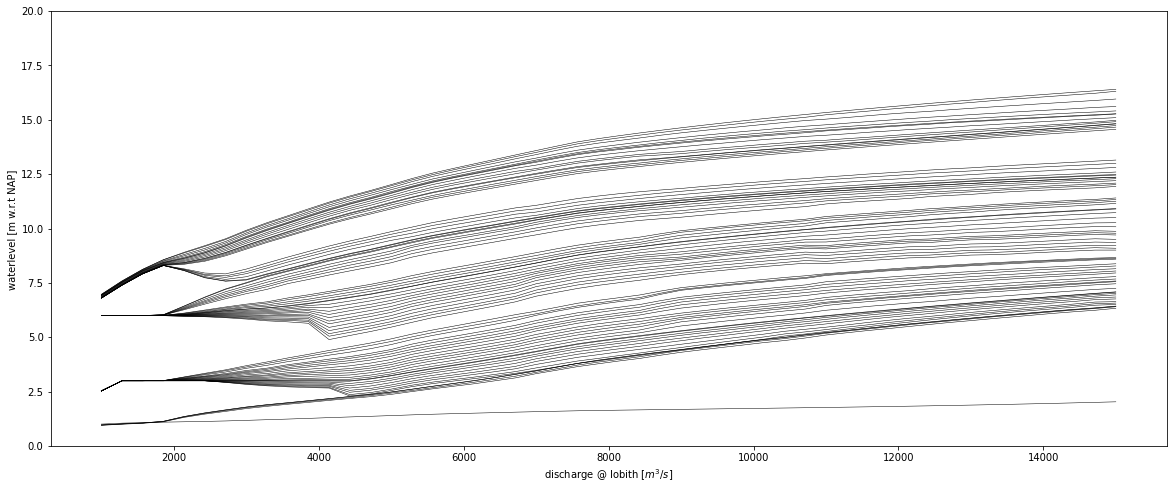

In [67]:
# plot at one location
discharge = np.linspace(1000, 15000)
fig, ax = plt.subplots(figsize=(20, 8))
for i in range(300, grouped_interpolator_gdf.shape[0]):
    waterlevel = grouped_interpolator_gdf.iloc[i]['interpolate'](discharge)
    ax.plot(discharge, waterlevel, 'k-', alpha=1, linewidth=0.5)
ax.set_xlabel('discharge @ lobith [$m^3/s$]')
ax.set_ylabel('waterlevel [m w.r.t NAP] ')
ax.set_ylim(0, 20)

<AxesSubplot:>

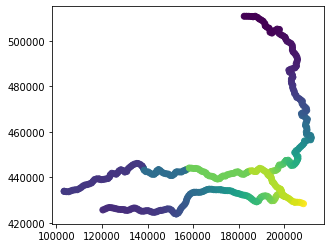

In [45]:
# map for 1 discharge level
waterlevels = grouped_interpolator_gdf['interpolate'].apply(lambda x: x(1000))
gpd.GeoDataFrame({"h": waterlevels}, geometry=grouped_interpolator_gdf['geometry']).plot('h')


## Old code

In [10]:
# read kilometermarkering
kmm_df= gpd.read_file(kmmarkering, crs=28992)

# read vaarwegvakken
vwv_df = gpd.read_file(vaarwegvakken, crs=28992)

print(vwv_df.crs)

vwv = {}
kmm = {}
waterdepth = {}

# Dict with vaarwegvakken per River
for key, value in sheet_names.items():
    # Select vaarwegvakken for River
    vwv[key] = vwv_df.loc[vwv_df["vrt_naam"].str.contains(value, case=False)]
    # Select kilometermarkeringen
    kmm[key] = kmm_df.loc[kmm_df["vwk_id"].isin(vwv[key]["vwk_id"])]
    # Merge kilometermarkering with waterdepth data
    waterdepth[key] = df[key].merge(kmm[key], how="left", left_index=True, right_index=False, right_on="gtlwaarde" ).set_index('gtlwaarde')
    


ws = pd.concat([waterdepth["Bovenrijn-Waal"], waterdepth["Pkan-NRijn-Lek"], waterdepth["IJssel"]])

ws

NameError: name 'kmmarkering' is not defined

In [ ]:
vwv_gdf

In [ ]:
# Not all records have a geometry. Remove all data without geometry
# This is data between kilometermarkeringen and some points in germany
ws = ws.loc[~ws['geometry'].isnull()]
ws

In [ ]:
# Transform geometry


ws = gpd.GeoDataFrame(ws, crs=28992, geometry="geometry")

# correct crs
ws = ws.to_crs(4326)

ws

In [ ]:


# for col in ws.columns:
#     ws = ws.rename(columns={col: str(col)})


In [ ]:
ws

In [ ]:
# Pivot dataframe l for a waterdepth as function of the discharge at Lobith

values = []
ids = []

for col in ws.columns:
    if type(col) is float:
        values.append(col)
    else:
        ids.append(col)

ws = ws.melt(id_vars=ids, value_vars=values).rename(columns={"variable": "discharge", "value": "ws"})

In [ ]:
ws

In [ ]:
ws.to_file("ws.geojson", driver='GeoJSON')